In [9]:
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from keras.layers import PReLU
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Input, Flatten, Conv1D,Dropout, MaxPooling1D
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder


In [10]:
data_folder = 'data/P_data'
data_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

data_dict = {}

for file in data_files:
    name = file.split('.')[0]
    data = pd.read_csv(os.path.join(data_folder,file))
    data_dict[name] = data

bray_global = data_dict['bray_global']
bray_afrlac = data_dict['bray_afrlac']
olsen_global = data_dict['olsen_global']
olsen_afrlac = data_dict['olsen_afrlac']
# Need to convert the WRB.SOIL.TYPE to numbers
encoder = LabelEncoder()
stp_global = data_dict['stp_global']
stp_afrlac = data_dict['stp_afrlac']

# Fit the encoder and transform the column
stp_global['WRB.SOIL.TYPE'] = encoder.fit_transform(stp_global['WRB.SOIL.TYPE'])
stp_afrlac['WRB.SOIL.TYPE'] = encoder.transform(stp_afrlac['WRB.SOIL.TYPE'])  # use transform, not fit_transform

In [11]:
stp_global.head

<bound method NDFrame.head of       LONGITUDE   LATITUDE   p_avg    SOC        SAND        CLAY        MAT   
0     18.316670  68.416670  1119.3  266.0  470.807453  120.000000  -2.000000  \
1     18.316670  68.416670   873.4  296.0  470.807453  120.000000  -2.000000   
2     18.316670  68.416670  1322.5  171.0  470.807453  120.000000  -2.000000   
3     18.316667  68.416667  1200.0  171.0  470.807453  120.062112  -5.000000   
4     18.200000  68.350000  1168.2  266.0  472.750000  160.000000  -5.000000   
...         ...        ...     ...    ...         ...         ...        ...   
4556 -72.200000 -40.767000   355.0   55.0  900.000000   50.000000   7.600000   
4557 -73.150000 -40.900000  1010.0   80.0  396.835400  220.000000  10.800000   
4558 -71.300000 -41.000000   589.0  108.0  650.000000  100.000000   8.133333   
4559 -71.300000 -41.000000   724.0   54.0  650.000000  100.000000   8.166667   
4560 -71.300000 -41.000000   735.0   70.0  650.000000  100.000000   8.200000   

         

In [12]:
# Select the features and response
X_bray_global = bray_global.drop(['p_avg', 'LONGITUDE', 'LATITUDE', 'GEO3major'], axis=1).values
y_bray_global = bray_global['p_avg'].values

X_bray_afrlac = bray_afrlac.drop(['p_avg', 'LONGITUDE', 'LATITUDE', 'GEO3major'], axis=1).values
y_bray_afrlac = bray_afrlac['p_avg'].values

X_olsen_afrlac = olsen_afrlac.drop(['p_avg', 'LONGITUDE', 'LATITUDE', 'GEO3major'], axis=1).values
y_olsen_afrlac = olsen_afrlac['p_avg'].values

X_olsen_global = olsen_global.drop(['p_avg', 'LONGITUDE', 'LATITUDE', 'GEO3major'], axis=1).values
y_olsen_global = olsen_global['p_avg'].values

X_stp_afrlac = stp_afrlac.drop(['p_avg', 'LONGITUDE', 'LATITUDE', 'GEO3major'], axis=1).values
y_stp_afrlac = stp_afrlac['p_avg'].values

X_stp_global = stp_global.drop(['p_avg', 'LONGITUDE', 'LATITUDE', 'GEO3major'], axis=1).values
y_stp_global = stp_global['p_avg'].values


In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_olsen_afrlac, y_olsen_afrlac, test_size=0.2, random_state=42)

In [14]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
# Define the DNN model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.04))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

In [16]:
# Evaluate the model
mse = model.evaluate(X_test, y_test)
print("Mean squared error: ", mse)

2/2 [==============================] - 0s 3ms/step - loss: 734.8987
Mean squared error:  734.8987426757812


In [17]:
# Calculate and print the correlation coefficients
corr_train = np.corrcoef(y_train, model.predict(X_train).flatten())[0, 1]
corr_test = np.corrcoef(y_test, model.predict(X_test).flatten())[0, 1]
print("Correlation coefficient for training data: ", corr_train)
print("Correlation coefficient for test data: ", corr_test)



2/2 [==============================] - 0s 1ms/step
Correlation coefficient for training data:  0.7347271698652619
Correlation coefficient for test data:  0.2848631961988715


In [18]:
# For the whole data

# Get the predictions
y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()

# Concatenate the actual values
y = np.concatenate((y_train, y_test))

# Concatenate the predicted values
y_pred = np.concatenate((y_train_pred, y_test_pred))

# Calculate the correlation
corr = np.corrcoef(y, y_pred)[0, 1]

print('Correlation for the whole data: ', corr)


2/2 [==============================] - 0s 3ms/step
Correlation for the whole data:  0.6300027666216124


In [19]:
y_pred

array([ 3.5409882 , 25.908842  ,  6.751076  , 23.317253  , 14.675838  ,
       41.0444    , 45.56644   , 42.87      ,  6.7235503 ,  3.541074  ,
       39.530354  ,  2.2219827 ,  1.7122087 , 12.1924305 ,  2.3657162 ,
        7.496493  ,  8.956787  , 26.024954  ,  8.959626  , 11.155085  ,
       12.163205  , 20.094942  , 18.681988  , 41.112385  , 51.174694  ,
        9.724366  ,  6.6947584 ,  2.5750928 , 12.916981  ,  3.2557688 ,
        6.7240787 , 62.59988   ,  2.3665957 ,  5.7473226 , 25.900549  ,
        6.724213  , 41.109295  , 13.449588  , 29.758139  , 41.112766  ,
        3.1417444 , 18.66884   ,  1.7168924 , 11.653786  ,  4.585546  ,
        1.3566284 , 25.88396   , 79.089096  ,  3.1433656 , 18.698778  ,
        6.7239776 , 27.066664  ,  6.7243085 ,  6.351468  ,  3.2550647 ,
        8.536994  , 40.36932   ,  4.0768147 ,  3.220557  ,  3.2195733 ,
       27.085798  ,  2.6665442 , 88.199104  ,  6.7236934 ,  6.724122  ,
       25.892254  , 25.358067  , 13.133539  , 16.204706  ,  8.53

In [21]:
y

array([  4.  ,  14.  ,   4.  ,  20.  ,  32.  ,  47.  ,  54.7 ,  42.  ,
        16.  ,   6.  ,  42.  ,   4.  ,   3.6 ,  11.  ,   1.  ,  14.  ,
        21.  ,  62.  ,   7.  ,  11.  ,  21.  ,   9.  ,   8.  ,   7.  ,
        55.  ,  20.  ,   7.5 ,   4.1 ,   7.9 ,   1.  ,   8.  ,  66.  ,
         0.5 ,   1.  ,  13.  ,   4.  ,  71.6 ,   6.  ,  11.  ,   2.9 ,
         3.  ,  70.  ,   3.1 ,   4.39,   2.  ,   0.6 ,   6.  ,  82.  ,
         1.  ,   4.  ,   9.  ,  19.  ,   3.  ,   9.4 ,   3.  ,  12.  ,
        45.  ,   0.7 ,   7.7 ,   3.1 ,  18.  ,   7.1 ,  99.  ,  15.  ,
         6.  ,  11.  ,  17.  ,  10.  ,   8.  ,  13.  ,  48.  ,  28.  ,
         2.  ,  11.  ,  47.  ,  19.  ,   1.  ,  12.  ,   2.  ,  81.  ,
        10.  ,   0.3 ,   7.  ,   0.7 ,   0.4 ,  89.3 ,  20.  ,  42.  ,
         3.2 ,   2.7 ,   3.  ,  54.  ,   1.  ,  29.  ,  75.  ,   5.  ,
         6.  ,  39.  ,   2.7 ,   5.  ,   9.  ,  35.  ,  19.  ,  30.  ,
         3.  ,   0.8 ,  17.  ,  81.  ,   4.  ,  12.  ,  11.  ,   5.5 ,
      

In [170]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='PReLU', input_shape=(X_train.shape[1], 1)))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, epochs=100, batch_size=32, validation_data=(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test))


Epoch 1/100
6/6 [==============================] - 1s 26ms/step - loss: 889.0798 - mean_squared_error: 889.0798 - val_loss: 930.0989 - val_mean_squared_error: 930.0989
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 875.1602 - mean_squared_error: 875.1602 - val_loss: 912.2718 - val_mean_squared_error: 912.2718
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 848.1639 - mean_squared_error: 848.1639 - val_loss: 869.7541 - val_mean_squared_error: 869.7541
Epoch 4/100
6/6 [==============================] - 0s 6ms/step - loss: 778.1361 - mean_squared_error: 778.1361 - val_loss: 778.5384 - val_mean_squared_error: 778.5384
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 674.4336 - mean_squared_error: 674.4336 - val_loss: 658.8039 - val_mean_squared_error: 658.8039
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 601.8342 - mean_squared_error: 601.8342 - val_loss: 671.6166 - val_mean_squared_error: 671.6

Epoch 50/100
6/6 [==============================] - 0s 6ms/step - loss: 330.3880 - mean_squared_error: 330.3880 - val_loss: 692.4963 - val_mean_squared_error: 692.4963
Epoch 51/100
6/6 [==============================] - 0s 5ms/step - loss: 340.4246 - mean_squared_error: 340.4246 - val_loss: 689.4275 - val_mean_squared_error: 689.4275
Epoch 52/100
6/6 [==============================] - 0s 6ms/step - loss: 328.6575 - mean_squared_error: 328.6575 - val_loss: 684.8428 - val_mean_squared_error: 684.8428
Epoch 53/100
6/6 [==============================] - 0s 6ms/step - loss: 349.8650 - mean_squared_error: 349.8650 - val_loss: 700.9725 - val_mean_squared_error: 700.9725
Epoch 54/100
6/6 [==============================] - 0s 5ms/step - loss: 343.7594 - mean_squared_error: 343.7594 - val_loss: 679.5385 - val_mean_squared_error: 679.5385
Epoch 55/100
6/6 [==============================] - 0s 5ms/step - loss: 328.9344 - mean_squared_error: 328.9344 - val_loss: 674.9024 - val_mean_squared_error: 6

Epoch 99/100
6/6 [==============================] - 0s 6ms/step - loss: 289.4623 - mean_squared_error: 289.4623 - val_loss: 617.4018 - val_mean_squared_error: 617.4018
Epoch 100/100
6/6 [==============================] - 0s 6ms/step - loss: 267.7813 - mean_squared_error: 267.7813 - val_loss: 619.8228 - val_mean_squared_error: 619.8228


In [173]:
# Calculate and print the correlation coefficients
corr_train = np.corrcoef(y_train, model.predict(X_train).flatten())[0, 1]
corr_test = np.corrcoef(y_test, model.predict(X_test).flatten())[0, 1]
print("Correlation coefficient for training data: ", corr_train)
print("Correlation coefficient for test data: ", corr_test)

2/2 [==============================] - 0s 2ms/step
Correlation coefficient for training data:  0.7110708697638026
Correlation coefficient for test data:  0.2196981027370806


In [174]:
# For the whole data

# Get the predictions
y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()

# Concatenate the actual values
y = np.concatenate((y_train, y_test))

# Concatenate the predicted values
y_pred = np.concatenate((y_train_pred, y_test_pred))

# Calculate the correlation
corr = np.corrcoef(y, y_pred)[0, 1]

print('Correlation for the whole data: ', corr)


2/2 [==============================] - 0s 2ms/step
Correlation for the whole data:  0.6236473058480091


In [182]:
# Reshape the data for the RNN
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the RNN model
model = Sequential()
#model.add(LSTM(units=64, return_sequences=True, input_shape=(1, X_train.shape[1])))
#model.add(Dropout(0.2))
#model.add(LSTM(units=32))
#model.add(Dropout(0.2))
#model.add(Dense(units=1, activation='linear'))

model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history = model.fit(X_train_rnn, y_train, epochs=50, batch_size=32, validation_data=(X_test_rnn, y_test))

Epoch 1/50


2023-05-10 15:48:11.142139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 15:48:11.143079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 15:48:11.144074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 2s 73ms/step - loss: 891.5819 - val_loss: 939.0698
Epoch 2/50
6/6 [==============================] - 0s 9ms/step - loss: 889.4981 - val_loss: 937.4917
Epoch 3/50
1/6 [====>.........................] - ETA: 0s - loss: 781.0997

2023-05-10 15:48:12.980755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 15:48:12.981804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 15:48:12.982948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 10ms/step - loss: 887.7739 - val_loss: 935.2857
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 885.0895 - val_loss: 931.1456
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 878.7733 - val_loss: 918.9371
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 855.4083 - val_loss: 870.5142
Epoch 7/50
6/6 [==============================] - 0s 10ms/step - loss: 790.2545 - val_loss: 792.7571
Epoch 8/50
6/6 [==============================] - 0s 9ms/step - loss: 728.9414 - val_loss: 738.6707
Epoch 9/50
6/6 [==============================] - 0s 8ms/step - loss: 670.6570 - val_loss: 688.8562
Epoch 10/50
6/6 [==============================] - 0s 11ms/step - loss: 622.5527 - val_loss: 650.0843
Epoch 11/50
6/6 [==============================] - 0s 11ms/step - loss: 595.7784 - val_loss: 624.5270
Epoch 12/50
6/6 [==============================] - 0s 9ms/step - loss: 574.5494 - val_loss: 614.3625
E

In [187]:
# Calculate and print the correlation coefficients
corr_train = np.corrcoef(y_train, model.predict(X_train_rnn).flatten())[0, 1]
corr_test = np.corrcoef(y_test, model.predict(X_test_rnn).flatten())[0, 1]
print("Correlation coefficient for training data: ", corr_train)
print("Correlation coefficient for test data: ", corr_test)

2/2 [==============================] - 0s 2ms/step
Correlation coefficient for training data:  0.2801753630653519
Correlation coefficient for test data:  0.04376691288251487


In [188]:
# For the whole data

# Get the predictions
y_train_pred = model.predict(X_train_rnn).flatten()
y_test_pred = model.predict(X_test_rnn).flatten()

# Concatenate the actual values
y = np.concatenate((y_train, y_test))

# Concatenate the predicted values
y_pred = np.concatenate((y_train_pred, y_test_pred))

# Calculate the correlation
corr = np.corrcoef(y, y_pred)[0, 1]

print('Correlation for the whole data: ', corr)


2/2 [==============================] - 0s 2ms/step
Correlation for the whole data:  0.23438017606138897


In [294]:
# Define the input shape
input_shape = X_train.shape[1]

# Define the autoencoder architecture
input_data = Input(shape=(input_shape,))
encoded = Dense(64, activation='relu')(input_data)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(input_shape, activation='sigmoid')(decoded)

# Create the autoencoder model
autoencoder = Model(inputs=input_data, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Fit the model
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.2)

# Get the encoded features
encoder = Model(inputs=input_data, outputs=encoded)
encoded_features = encoder.predict(X_train)


Epoch 1/100
5/5 [==============================] - 1s 23ms/step - loss: 1.1870 - val_loss: 1.1410
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 1.1521 - val_loss: 1.1105
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 1.1185 - val_loss: 1.0774
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 1.0830 - val_loss: 1.0405
Epoch 5/100
5/5 [==============================] - 0s 9ms/step - loss: 1.0440 - val_loss: 0.9989
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 1.0012 - val_loss: 0.9533
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 0.9564 - val_loss: 0.9062
Epoch 8/100
5/5 [==============================] - 0s 7ms/step - loss: 0.9115 - val_loss: 0.8617
Epoch 9/100
5/5 [==============================] - 0s 7ms/step - loss: 0.8684 - val_loss: 0.8233
Epoch 10/100
5/5 [==============================] - 0s 7ms/step - loss: 0.8316 - val_loss: 0.7925
Epoch 11/100
5/5 [==========

5/5 [==============================] - 0s 8ms/step - loss: 0.5612 - val_loss: 0.5516
Epoch 85/100
5/5 [==============================] - 0s 8ms/step - loss: 0.5611 - val_loss: 0.5514
Epoch 86/100
5/5 [==============================] - 0s 8ms/step - loss: 0.5610 - val_loss: 0.5515
Epoch 87/100
5/5 [==============================] - 0s 8ms/step - loss: 0.5608 - val_loss: 0.5511
Epoch 88/100
5/5 [==============================] - 0s 8ms/step - loss: 0.5607 - val_loss: 0.5507
Epoch 89/100
5/5 [==============================] - 0s 6ms/step - loss: 0.5606 - val_loss: 0.5507
Epoch 90/100
5/5 [==============================] - 0s 6ms/step - loss: 0.5605 - val_loss: 0.5505
Epoch 91/100
5/5 [==============================] - 0s 6ms/step - loss: 0.5604 - val_loss: 0.5503
Epoch 92/100
5/5 [==============================] - 0s 5ms/step - loss: 0.5603 - val_loss: 0.5502
Epoch 93/100
5/5 [==============================] - 0s 6ms/step - loss: 0.5603 - val_loss: 0.5498
Epoch 94/100
5/5 [===============

In [1]:
# Calculate and print the correlation coefficients
corr_train = np.corrcoef(X_train.flatten(), autoencoder.predict(X_train).flatten())[0, 1]
corr_test = np.corrcoef(X_test.flatten(), autoencoder.predict(X_test).flatten())[0, 1]
print("Correlation coefficient for training data: ", corr_train)
print("Correlation coefficient for test data: ", corr_test)

NameError: name 'np' is not defined

In [296]:
# Get the predictions
y_train_pred = autoencoder.predict(X_train).flatten()
y_test_pred = autoencoder.predict(X_test).flatten()

# Concatenate the actual values
y = np.concatenate((X_train.flatten(), X_test.flatten()))

# Concatenate the predicted values
y_pred = np.concatenate((y_train_pred, y_test_pred))

# Calculate the correlation
corr = np.corrcoef(y, y_pred)[0, 1]

print('Correlation for the whole data: ', corr)

2/2 [==============================] - 0s 1ms/step
Correlation for the whole data:  0.8093993023752292


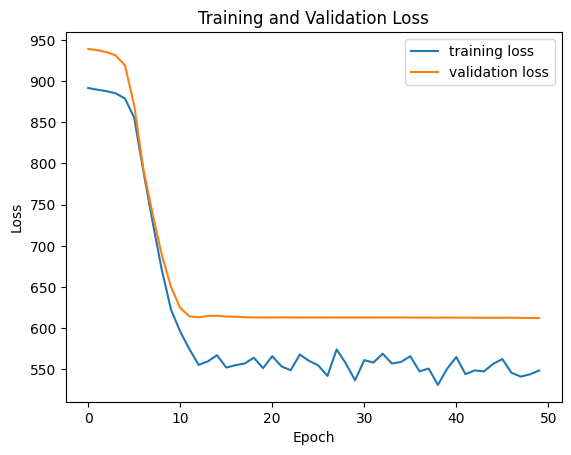

In [297]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



2/2 [==============================] - 0s 3ms/step


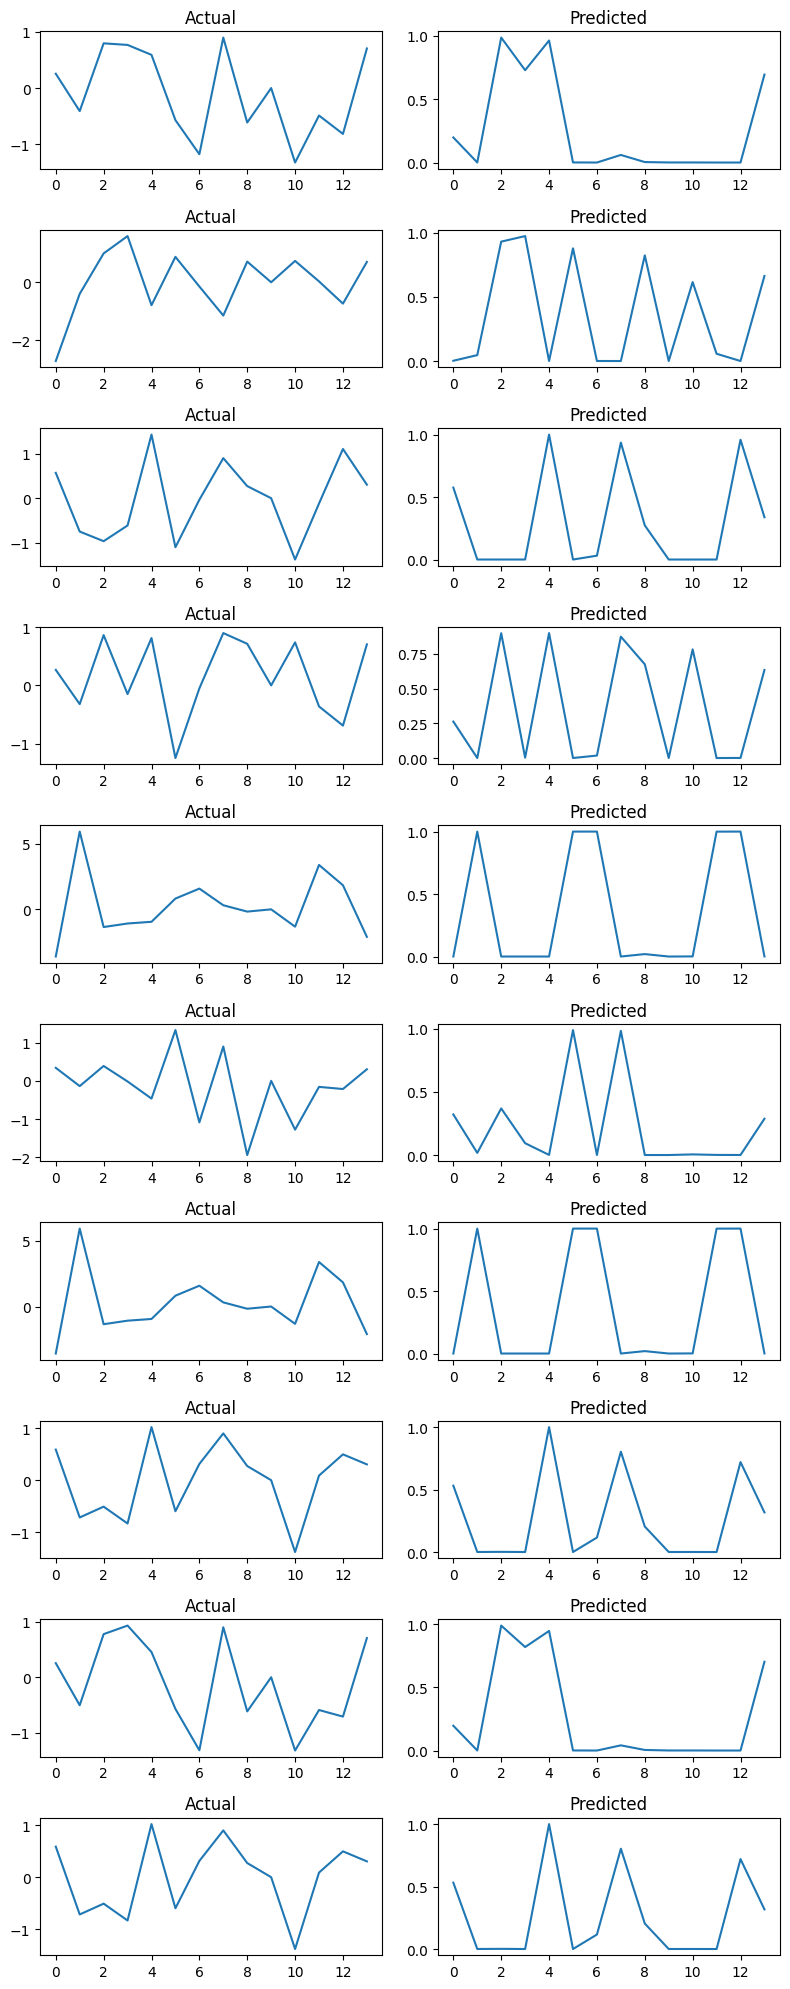

In [277]:
# Get the predictions for the test data
y_pred = autoencoder.predict(X_test)

# Plot the predicted vs actual values
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(8, 20))
for i in range(10):
    axs[i, 0].plot(X_test[i])
    axs[i, 0].set_title("Actual")
    axs[i, 1].plot(y_pred[i])
    axs[i, 1].set_title("Predicted")

plt.tight_layout()
plt.show()

8/8 [==============================] - 0s 677us/step


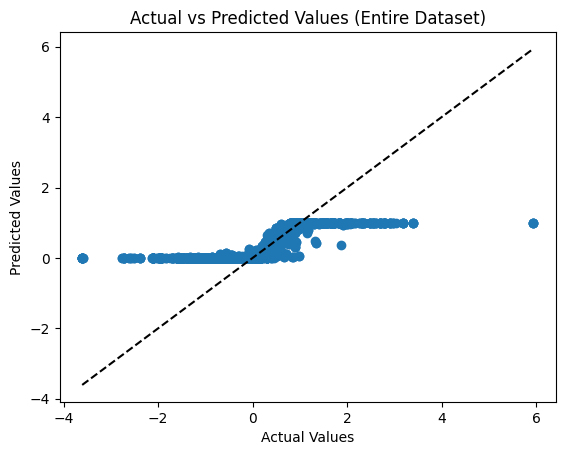

In [262]:
# Get the predictions for the entire dataset
y_pred_all = autoencoder.predict(X).flatten()

# Plot the predicted vs actual values
plt.scatter(X, y_pred_all)
plt.plot([X.min(), X.max()], [X.min(), X.max()], 'k--')
plt.title('Actual vs Predicted Values (Entire Dataset)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [215]:
bray_global['GEO3major'].unique()

array(['North America', 'Latin America and the Caribbean', 'Africa',
       'Europe', 'West Asia', 'Asia and the Pacific'], dtype=object)

In [216]:
# Define the source and target domains
source_continent_list = ["Africa", "Latin America and the Caribbean", "Asia and the Pacific"]
target_continent_list = ["Africa", "Latin America and the Caribbean"]

In [226]:
source_data = bray_global[bray_global["GEO3major"].isin(source_continent_list)].iloc[:, 2:-2].values
target_data = bray_global[bray_global["GEO3major"].isin(target_continent_list)].iloc[:, 2:-2].values

In [227]:
# Split the source data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(source_data, source_data[:, 0], test_size=0.2)

In [237]:
# Define the model
input_shape = X_train.shape[1]
class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_shape, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [238]:
# Train the model on the source domain
#net = Net()
# Define the model
input_shape = X_train.shape[1]
net = Net(input_shape)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [240]:
# Train the model on the source domain
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(zip(X_train, y_train), 0):
        inputs, label = data
        label = torch.Tensor([label])
        inputs = torch.Tensor([inputs]).float()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

In [241]:
# Adapt the model to the target domain
adapt_data = np.concatenate((source_data, target_data), axis=0)
adapt_loader = torch.utils.data.DataLoader(adapt_data, batch_size=32, shuffle=True)

In [242]:
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(adapt_loader, 0):
        inputs = data[:, 1:]
        labels = data[:, 0]
        labels = torch.Tensor(labels)
        inputs = torch.Tensor(inputs).float()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x13 and 14x50)

In [244]:
# Define the model
class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_shape-1, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train the model on the source domain
input_shape = X_train.shape[1]
net = Net(input_shape)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(zip(X_train, y_train), 0):
        inputs, label = data
        label = torch.Tensor([label])
        inputs = torch.Tensor(inputs).float()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

# Adapt the model to the target domain
adapt_data = np.concatenate((source_data, target_data), axis=0)
adapt_loader = torch.utils.data.DataLoader(adapt_data, batch_size=32, shuffle=True)
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(adapt_loader, 0):
        inputs = data[:,:-1]
        labels = data[:,-1]
        inputs = torch.Tensor(inputs).float()
        labels = torch.Tensor(labels).float()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x14 and 13x50)